# Inferring the actitude toward self-driving cars from tweets using an NN-based supervised classification algorithm

#### Objective: infer the reactions of users to self-driving cars from their tweets
#### DataSet: the data set is provided by kaggle and can be found in the this link:
    

#### For this approach we will
    
    •Preprocess the data
        - removing  extrange characters 
        - parsing html formated strings
        - removing links and #,@
        - expanding contractions 
        
#### Main approach:
    •feature extraction (tfidf vectorizer)
    •Train our model (in this case a Multilayer neural network)
    •Test the MNN
    
#### Secondary Approaches
   **CNN**
  
    •feature extraction (word2vec)
    •Train a CNN 
    •Test the CNN
    
   **LSTM**
   
    •feature extraction (also a TFIDF variation)
    •Train a LSTM net
    •Test the LSTM net
    
 And Finally comparation between reasults and embeddings 
    

### Important! before running this notebook please configure the enviroment Running the following cell

#### Better to use in linux/unix

In [ ]:
"""!conda env create -f enviroment.yml
!source activate sentimentAnalysis
#And then reload the notebook doing
!jupyter notebook P38_TwitterSelfDrivingCars.ipynb"""

#### Preprocessing the data

##### Downloading the dataset from https://www.kaggle.com/c/self-driving-cars-sentiment-analysis/data

In [2]:
import pandas as pd
import io
import requests
import numpy as np
testing_data=pd.read_csv("test_data.csv")
training_data=pd.read_csv("train_data.csv")

In [3]:
training_data[37:45]

,sentiment,text
37,3,How is an automated vehicle supposed to behave...
38,3,#AnnArbor is home to ongoing experiment w/ tal...
39,3,WO2012158248A1 Collaborative Vehicle Control U...
40,3,"Wow - ""@AUVSI: Google goes commercial: Company..."
41,3,Blogged: Automated vehicles and the Motor Vehi...
42,3,California's new automated vehicle regulations...
43,3,"Last year, Google warned it would have an auto..."
44,3,@ford video: sensors on Fusion Hybrid Automate...


It looks like the data hasent being converted to text because there is some weird characters,"hashtags" and mentions in the tweets that could diminish the perfomance of the prediction, the first steps in the cleaning will be 

    - Parsing html to text
    - Remove links 
    - Remove "@" from mentions (I decided not to remove mentions because it carryes some information) and # from hashtags??
    - Remove weird Characters
    - Removing punctuations.
    
so lets define a cleaning function

In [4]:
import re
from bs4 import BeautifulSoup
from nltk.tokenize import WordPunctTokenizer
import string

contractions_dict = {
"ain't": "am not / are not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is",
"i'd": "I had / I would",
"i'd've": "I would have",
"i'll": "I shall / I will",
"i'll've": "I shall have / I will have",
"i'm": "I am",
"i've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have",
"w/": "with"
}

contractions_re = re.compile('(%s)' % '|'.join(contractions_dict.keys()))

def replace(match):
    return contractions_dict[match.group(0)]
def expand_contractions(s, contractions_dict=contractions_dict):
    return contractions_re.sub(replace, s)

tok = WordPunctTokenizer()
remove_punctuation=str.maketrans('','',string.punctuation)
removeLinks=re.compile("https?://[A-Za-z0-9./]+")


def tweet_cleaner(text):
    #parsing html
    soup = BeautifulSoup(text, 'html.parser')
    souped = soup.get_text()
    #removing links and @ 
    stripped = removeLinks.sub('', souped)
    #removing weird characters
    clean = stripped.encode("utf-8-sig").decode("ascii","ignore")
    #expanding contractions 
    clean=expand_contractions(clean)
    #removing punctuation
    clean=clean.translate(remove_punctuation)
    lower_case = clean.lower()
    # During the letters_only process two lines above, it has created unnecessay white spaces,
    # I will tokenize and join together to remove unneccessary white spaces
    #words = tok.tokenize(clean)
    words = tok.tokenize(lower_case)
    return (" ".join(words)).strip()

##### Whit the cleaning function designed now is possible to preprocess the text in order to increase perfomance and diminish ambiguity 

i.e lets clean the following samples

In [5]:
example=training_data.text[14]
example2=training_data.text[38]

In [6]:
print(f"Original: {example}\n\nCleaned:{tweet_cleaner(example)}")

Original: ̢���@latimesautos: Audi gets first permit to test self-driving cars on California roads: http://t.co/L71qpM42lY http://t.co/CWBbOAwahL̢���� ̡�����_̡�����

Cleaned:latimesautos audi gets first permit to test selfdriving cars on california roads


In [7]:
print(f"Original: {example2}\n\nCleaned: {tweet_cleaner(example2)}")

Original: #AnnArbor is home to ongoing experiment w/ talking #cars? "@freep: Automated vehicle test site groundbreaking today http://t.co/QwbtJbSBwy"

Cleaned: annarbor is home to ongoing experiment with talking cars freep automated vehicle test site groundbreaking today


***Now its time to clean the data***

In [8]:
print ("Cleaning and parsing the tweets...\n")
for i in range(0,training_data.shape[0]):
    if( (i+1)%1000 == 0 ):
        print(f"{i+1} Tweets of {training_data.shape[0]} has been processed")                                                                 
    training_data.at[i,"text"]=tweet_cleaner(training_data.text[i])
print("Data Cleaned!!")      

Cleaning and parsing the tweets...

1000 Tweets of 5250 has been processed
2000 Tweets of 5250 has been processed
3000 Tweets of 5250 has been processed
4000 Tweets of 5250 has been processed
5000 Tweets of 5250 has been processed
Data Cleaned!!


In [9]:
training_data[37:45]

,sentiment,text
37,3,how is an automated vehicle supposed to behave...
38,3,annarbor is home to ongoing experiment with ta...
39,3,wo2012158248a1 collaborative vehicle control u...
40,3,wow auvsi google goes commercial company teams...
41,3,blogged automated vehicles and the motor vehic...
42,3,californias new automated vehicle regulations ...
43,3,last year google warned it would have an autom...
44,3,ford video sensors on fusion hybrid automated ...


_**I store the cleaned data set for futher uses**_

In [10]:
training_data.to_csv("cleaned_trainig_data.csv",encoding='utf-8',index=False)

***Also the testing data***

In [11]:
print ("Cleaning and parsing the tweets...\n")
for i in range(0,testing_data.shape[0]):
    if( (i+1)%200 == 0 ):
        print(f"{i+1} Tweets of {testing_data.shape[0]} has been processed")                                                                 
    testing_data.at[i,"text"]=tweet_cleaner(testing_data.text[i])
print("Data Cleaned!!")
testing_data.to_csv("cleaned_testing_data.csv",encoding='utf-8',index=False)

Cleaning and parsing the tweets...

200 Tweets of 1693 has been processed
400 Tweets of 1693 has been processed
600 Tweets of 1693 has been processed
800 Tweets of 1693 has been processed
1000 Tweets of 1693 has been processed
1200 Tweets of 1693 has been processed
1400 Tweets of 1693 has been processed
1600 Tweets of 1693 has been processed
Data Cleaned!!


***The next step is just a comprobation it can be skipped***

In [12]:
df=pd.read_csv("cleaned_trainig_data.csv")

In [13]:
df.head()

,sentiment,text
0,5,two places id invest all my money if i could 3...
1,5,awesome google driverless cars will help the b...
2,2,if google maps cannot keep up with road constr...
3,2,autonomous cars seem way overhyped given the t...
4,3,just saw google selfdriving car on i34 it was ...


## Data representation (feature extraction tfidf and wordvectorizer)

### Here we start with the main approach
For this time we will use a tfidf vectorizer which s a word embedding that could represent not only the amount of word but also reflect how important a word is to a document in a collection

then i will use wordvectorizer that will count the ocurrency of the words in a given document 

In [14]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
cvec = CountVectorizer()
tvec = TfidfVectorizer()


## Training and testing
Now in the previous part we only defined our vectorizer to extract the data features but we will to this on the fly

The next steps will be define a function called accuracy summary that is capable of test the accuracy of the model and measure the training time

After that the nfeature accuracy checker will check the accuracy using  unigrams,bigrams and trigrams 

So first before to desing the NN i will use a simple linear regression and see which amount of features in the tfidf vectorizer is the best to use and the i will select the number of nodes that the NN needs based on this results.

Finally we will compare the results using both data representation (word vectorizer and tfidvectorizer)

In [15]:
from time import time
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder

def decodeHotEncode(datum):
    return np.argmax(datum)+1#because computers count from 0 and our clases starts in 1 :P

def accuracy_summary(model, x_train, y_train, x_validation, y_validation,null_accuracy):
    #label encoding
    onehotencoder = OneHotEncoder(categories="auto")
    y_train_categorical=onehotencoder.fit_transform(y_train.values.reshape(-1, 1)).toarray()
    y_validation_categorical=onehotencoder.transform(y_validation.values.reshape(-1, 1)).toarray()
    #when is always guessing the most common class (null accuracy)
    t0 = time()
    print(f"Train set:\nx: {x_train.shape} \ny: {y_train_categorical.shape}")
    print(f"Validation set:\nx: {x_validation.shape} \ny: {y_validation_categorical.shape}")
    
    model.fit_generator(generator=batch_generator(x_train, y_train_categorical, 32),
                        epochs=5, validation_data=(x_validation, y_validation_categorical),
                        steps_per_epoch=x_train.shape[0]/32)
   
    y_pred = model.predict(x_train)
    #deconding the predictions
    y_pred=[decodeHotEncode(i) for i in y_pred]
    train_test_time = time() - t0
    accuracy = accuracy_score(y_train, y_pred)
    print(f"{(y_train == y_pred).sum()} equal values:  of {y_train.shape[0]} samples")
    print (f"Null accuracy: {(null_accuracy*100)}%")
    print (f"Accuracy score: {(accuracy*100)}%")
    if accuracy > null_accuracy: # we have a good model :) (is guessing well the most part of time)
        print (f"The Model is {((accuracy-null_accuracy)*100)}% more accurate than null accuracy")
    elif accuracy == null_accuracy:# we have a  bad  model :( (is just guessing badly)
        print (f"The Model has the same accuracy with the null accuracy")
    else: # we have a very bad  model :'(  (is always confused with the most common class)
        print (f"The Model is {((null_accuracy-accuracy)*100)}% less accurate than null accuracy")
    print (f"Train and Test time: {train_test_time}s")
    print ("-"*100)
    return accuracy, train_test_time


## Then lets desing our model:
 in order to know the better configuration of the NN i will check the acurracy amoung different   number of features. [10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000]
 
For now I will have  neurons in the input layer as many of the features  and 64 neurons in the  hidden layer with Relu activation function applied because in this case i want the neurons to be activated as much as its posible so Relu defined as f(x)=max(0,x) are always activated when the values are non negativ, also relu has a lot of advantages like : computacionaly cheao and also it avoids the  vanishing gradient problem.Also I'm using the adam optimizerfor updating the parameters and minimising the cost of the neural network. And the KL divergence loss function and also compare it whit categorical_crossentropy and finaly the output layer whit the sigmoid activation function

        
 

In [16]:
seed = 7
np.random.seed(seed)
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Flatten


Using TensorFlow backend.


Before train train the model, Keras NN model cannot handle sparse matrix directly. The data has to be dense array or matrix, but transforming the whole training data Tfidf vectors of  to dense array won't fit into my RAM. So I had to define a function, which generates iterable generator object.The output should be a generator class object rather than arrays.

In [17]:
def batch_generator(X_data, y_data, batch_size):
    samples_per_epoch = X_data.shape[0]
    number_of_batches = samples_per_epoch/batch_size
    counter=0
    
    
    
    index = np.arange(np.shape(y_data)[0])
    while 1:
        index_batch = index[batch_size*counter:batch_size*(counter+1)]
        X_batch = X_data[index_batch,:].toarray()
        y_batch = y_data[index_batch]
        counter += 1
        yield X_batch,y_batch
        if (counter > number_of_batches):
            counter=0

In [18]:
def createModel(x_train,architecture):
    if(architecture==1):
        classifier = Sequential()
        classifier.add(Dense(64, activation='relu', input_dim=x_train.shape[1]))
        classifier.add(Dense(5, activation='sigmoid'))
        classifier.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
    elif(architecture==2):
        classifier = Sequential()
        classifier.add(Dense(300, activation='relu', input_dim=x_train.shape[1]))
        classifier.add(Dense(200, activation='relu'))
        classifier.add(Dense(100, activation='relu'))
        classifier.add(Dense(5, activation='sigmoid'))
        classifier.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
    return classifier
    

In [19]:
n_features = np.arange(1000,100001,1000)

print("We will check the acurracy for the following maxnumber the features:\n", n_features)
import keras
from keras_sequential_ascii import sequential_model_to_ascii_printout
def nfeature_accuracy_checker(x_train, y_train, x_validation, y_validation,null_accuracy,vectorizer=None, maxNumberOfFeatures=n_features, ngram_range=(1, 1),architecture=None):
    result = []
    actualNumberofeatures=0
    #feature extraction
    for n in n_features:
        keras.backend.clear_session()
        vectorizer.set_params(max_features=n, ngram_range=ngram_range)
        vectorizer.fit(x_train)
        x_train_tfidf = tvec.transform(x_train)
        x_validation_tfidf = tvec.transform(x_validation)
        if(x_train_tfidf.shape[1]>actualNumberofeatures):
            actualNumberofeatures=x_train_tfidf.shape[1]
            print("Number of features obtained: ",x_train_tfidf.shape[1])    
            model=createModel(x_train_tfidf,architecture=architecture)
            print("Designed model")
            sequential_model_to_ascii_printout(model)
            print (f"\nValidation result for {x_train_tfidf.shape[1]} features")
            nfeature_accuracy,tt_time = accuracy_summary(model, x_train_tfidf, y_train, x_validation_tfidf, y_validation,null_accuracy)
            result.append((n,nfeature_accuracy,tt_time))
        else:
            print("the maximum number of features has been reached")
            break
    return result

We will check the acurracy for the following maxnumber the features:
 [  1000   2000   3000   4000   5000   6000   7000   8000   9000  10000
  11000  12000  13000  14000  15000  16000  17000  18000  19000  20000
  21000  22000  23000  24000  25000  26000  27000  28000  29000  30000
  31000  32000  33000  34000  35000  36000  37000  38000  39000  40000
  41000  42000  43000  44000  45000  46000  47000  48000  49000  50000
  51000  52000  53000  54000  55000  56000  57000  58000  59000  60000
  61000  62000  63000  64000  65000  66000  67000  68000  69000  70000
  71000  72000  73000  74000  75000  76000  77000  78000  79000  80000
  81000  82000  83000  84000  85000  86000  87000  88000  89000  90000
  91000  92000  93000  94000  95000  96000  97000  98000  99000 100000]


In [20]:
from sklearn.model_selection import train_test_split

SEED = 2000
x_train, x_validation, y_train, y_validation = train_test_split(training_data.text,training_data.sentiment, test_size=0.2, random_state=SEED,stratify=training_data.sentiment)
print("Training set distribution:")
print(x_train.groupby(y_train).size().reset_index(name="counts"))
print("\nValidation set distribution:")
print(x_validation.groupby(y_validation).size().reset_index(name="counts"))
null_accuracy=x_train.groupby(y_train).size().max()/x_train.shape[0]

Training set distribution:
   sentiment  counts
0          1      61
1          2     378
2          3    2629
3          4     850
4          5     282

Validation set distribution:
   sentiment  counts
0          1      15
1          2      95
2          3     658
3          4     212
4          5      70


### Multilayer Perceptron
***Results for unigram whit different number of features***

In [21]:
feature_result_ugt = nfeature_accuracy_checker(x_train,y_train,x_validation,y_validation,null_accuracy,vectorizer=tvec,architecture=1)

Number of features obtained:  1000
Designed model
           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####        1000
               Dense   XXXXX -------------------     64064    99.5%
                relu   #####          64
               Dense   XXXXX -------------------       325     0.5%
             sigmoid   #####           5

Validation result for 1000 features
Train set:
x: (4200, 1000) 
y: (4200, 5)
Validation set:
x: (1050, 1000) 
y: (1050, 5)
Epoch 1/5
132/131 [==============================] - 1s 6ms/step - loss: 1.3439 - acc: 0.6072 - val_loss: 1.0886 - val_acc: 0.6267
Epoch 2/5
132/131 [==============================] - 1s 5ms/step - loss: 1.0330 - acc: 0.6259 - val_loss: 1.0234 - val_acc: 0.6267
Epoch 3/5
132/131 [==============================] - 1s 5ms/step - loss: 0.9551 - acc: 0.6267 - val_loss: 0.9774 - val_acc: 0.6276
Epoch 4/5
132/131 [==============================] - 1s 5ms/step - loss: 0.8709 - acc: 0.6477 - val_

***Results for Bigram whit different number of features***

In [22]:
n_features = np.arange(1000,100001,10000)
feature_result_bgt = nfeature_accuracy_checker(x_train,y_train,x_validation,y_validation,null_accuracy,vectorizer=tvec,maxNumberOfFeatures=n_features,ngram_range=(1,2),architecture=1)

Number of features obtained:  1000
Designed model
           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####        1000
               Dense   XXXXX -------------------     64064    99.5%
                relu   #####          64
               Dense   XXXXX -------------------       325     0.5%
             sigmoid   #####           5

Validation result for 1000 features
Train set:
x: (4200, 1000) 
y: (4200, 5)
Validation set:
x: (1050, 1000) 
y: (1050, 5)
Epoch 1/5
132/131 [==============================] - 1s 6ms/step - loss: 1.3343 - acc: 0.5980 - val_loss: 1.0912 - val_acc: 0.6267
Epoch 2/5
132/131 [==============================] - 1s 4ms/step - loss: 1.0398 - acc: 0.6259 - val_loss: 1.0304 - val_acc: 0.6267
Epoch 3/5
132/131 [==============================] - 1s 4ms/step - loss: 0.9658 - acc: 0.6295 - val_loss: 0.9839 - val_acc: 0.6333
Epoch 4/5
132/131 [==============================] - 1s 4ms/step - loss: 0.8752 - acc: 0.6593 - val_

***Results for Trigram whit different number of features***

In [23]:
n_features = np.arange(1000,100001,20000)
feature_result_tgt = nfeature_accuracy_checker(x_train,y_train,x_validation,y_validation,null_accuracy,vectorizer=tvec,maxNumberOfFeatures=n_features,ngram_range=(1,3),architecture=1)

Number of features obtained:  1000
Designed model
           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####        1000
               Dense   XXXXX -------------------     64064    99.5%
                relu   #####          64
               Dense   XXXXX -------------------       325     0.5%
             sigmoid   #####           5

Validation result for 1000 features
Train set:
x: (4200, 1000) 
y: (4200, 5)
Validation set:
x: (1050, 1000) 
y: (1050, 5)
Epoch 1/5
132/131 [==============================] - 1s 7ms/step - loss: 1.3358 - acc: 0.6200 - val_loss: 1.0880 - val_acc: 0.6267
Epoch 2/5
132/131 [==============================] - 1s 4ms/step - loss: 1.0312 - acc: 0.6259 - val_loss: 1.0250 - val_acc: 0.6267
Epoch 3/5
132/131 [==============================] - 1s 4ms/step - loss: 0.9622 - acc: 0.6262 - val_loss: 0.9884 - val_acc: 0.6276
Epoch 4/5
132/131 [==============================] - 1s 4ms/step - loss: 0.8951 - acc: 0.6347 - val_

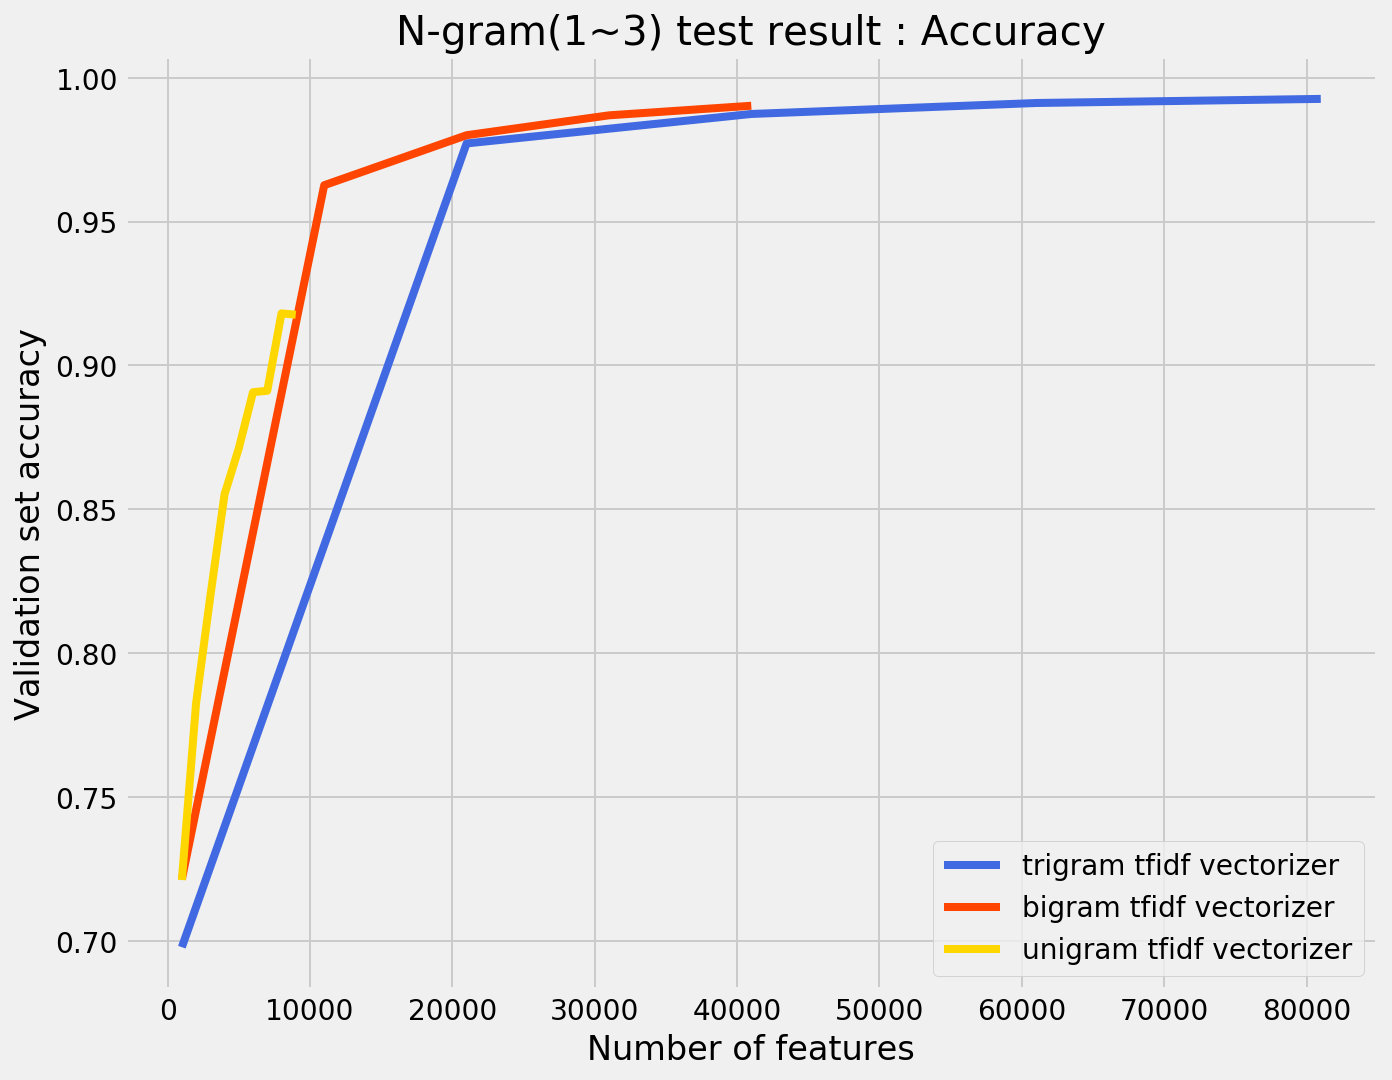

In [24]:
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('fivethirtyeight')
nfeatures_plot_tgt = pd.DataFrame(feature_result_tgt,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_bgt = pd.DataFrame(feature_result_bgt,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_ugt = pd.DataFrame(feature_result_ugt,columns=['nfeatures','validation_accuracy','train_test_time'])

plt.figure(figsize=(10,8))
plt.plot(nfeatures_plot_tgt.nfeatures, nfeatures_plot_tgt.validation_accuracy,label='trigram tfidf vectorizer',color='royalblue')
plt.plot(nfeatures_plot_bgt.nfeatures, nfeatures_plot_bgt.validation_accuracy,label='bigram tfidf vectorizer',color='orangered')
plt.plot(nfeatures_plot_ugt.nfeatures, nfeatures_plot_ugt.validation_accuracy, label='unigram tfidf vectorizer',color='gold')
plt.title("N-gram(1~3) test result : Accuracy")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend()


Now its time to see that  changing the arquitecture of the model is posible to improve the prediction 

In [25]:
n_features = np.arange(1000,100001,1000)
feature_result_ugt = nfeature_accuracy_checker(x_train,y_train,x_validation,y_validation,null_accuracy,vectorizer=tvec,architecture=2)

Number of features obtained:  1000
Designed model
           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####        1000
               Dense   XXXXX -------------------    300300    78.8%
                relu   #####         300
               Dense   XXXXX -------------------     60200    15.8%
                relu   #####         200
               Dense   XXXXX -------------------     20100     5.3%
                relu   #####         100
               Dense   XXXXX -------------------       505     0.1%
             sigmoid   #####           5

Validation result for 1000 features
Train set:
x: (4200, 1000) 
y: (4200, 5)
Validation set:
x: (1050, 1000) 
y: (1050, 5)
Epoch 1/5
132/131 [==============================] - 2s 13ms/step - loss: 1.1098 - acc: 0.6212 - val_loss: 1.0068 - val_acc: 0.6267
Epoch 2/5
132/131 [==============================] - 1s 10ms/step - loss: 0.8800 - acc: 0.6508 - val_loss: 0.9814 - val_acc: 0.6495
Epoch 3/5
1

In [26]:
n_features = np.arange(1000,100001,10000)
feature_result_bgt = nfeature_accuracy_checker(x_train,y_train,x_validation,y_validation,null_accuracy,vectorizer=tvec,maxNumberOfFeatures=n_features,ngram_range=(1,2),architecture=2)

Number of features obtained:  1000
Designed model
           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####        1000
               Dense   XXXXX -------------------    300300    78.8%
                relu   #####         300
               Dense   XXXXX -------------------     60200    15.8%
                relu   #####         200
               Dense   XXXXX -------------------     20100     5.3%
                relu   #####         100
               Dense   XXXXX -------------------       505     0.1%
             sigmoid   #####           5

Validation result for 1000 features
Train set:
x: (4200, 1000) 
y: (4200, 5)
Validation set:
x: (1050, 1000) 
y: (1050, 5)
Epoch 1/5
132/131 [==============================] - 2s 14ms/step - loss: 1.1093 - acc: 0.6222 - val_loss: 1.0172 - val_acc: 0.6267
Epoch 2/5
132/131 [==============================] - 1s 11ms/step - loss: 0.8987 - acc: 0.6546 - val_loss: 0.9899 - val_acc: 0.6419
Epoch 3/5
1

In [27]:
n_features = np.arange(1000,100001,20000)
feature_result_tgt = nfeature_accuracy_checker(x_train,y_train,x_validation,y_validation,null_accuracy,vectorizer=tvec,maxNumberOfFeatures=n_features,ngram_range=(1,3),architecture=2)

Number of features obtained:  1000
Designed model
           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####        1000
               Dense   XXXXX -------------------    300300    78.8%
                relu   #####         300
               Dense   XXXXX -------------------     60200    15.8%
                relu   #####         200
               Dense   XXXXX -------------------     20100     5.3%
                relu   #####         100
               Dense   XXXXX -------------------       505     0.1%
             sigmoid   #####           5

Validation result for 1000 features
Train set:
x: (4200, 1000) 
y: (4200, 5)
Validation set:
x: (1050, 1000) 
y: (1050, 5)
Epoch 1/5
132/131 [==============================] - 2s 14ms/step - loss: 1.1451 - acc: 0.6186 - val_loss: 1.0287 - val_acc: 0.6267
Epoch 2/5
132/131 [==============================] - 1s 11ms/step - loss: 0.9298 - acc: 0.6259 - val_loss: 0.9642 - val_acc: 0.6276
Epoch 3/5
1

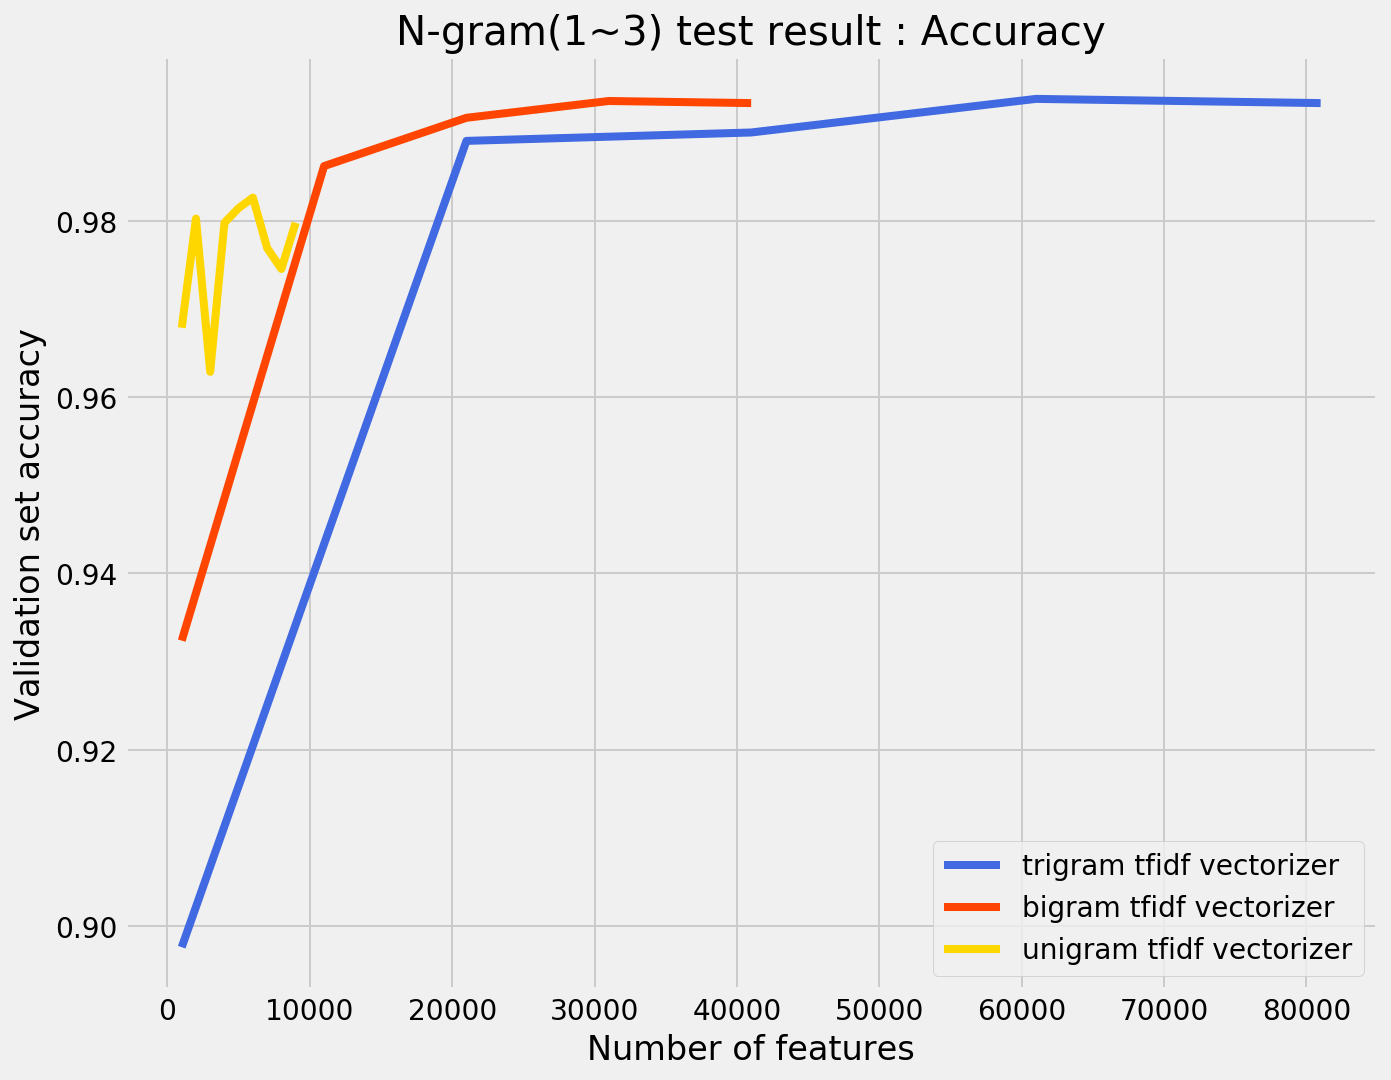

In [28]:
plt.style.use('fivethirtyeight')
nfeatures_plot_tgt = pd.DataFrame(feature_result_tgt,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_bgt = pd.DataFrame(feature_result_bgt,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_ugt = pd.DataFrame(feature_result_ugt,columns=['nfeatures','validation_accuracy','train_test_time'])

plt.figure(figsize=(10,8))
plt.plot(nfeatures_plot_tgt.nfeatures, nfeatures_plot_tgt.validation_accuracy,label='trigram tfidf vectorizer',color='royalblue')
plt.plot(nfeatures_plot_bgt.nfeatures, nfeatures_plot_bgt.validation_accuracy,label='bigram tfidf vectorizer',color='orangered')
plt.plot(nfeatures_plot_ugt.nfeatures, nfeatures_plot_ugt.validation_accuracy, label='unigram tfidf vectorizer',color='gold')
plt.title("N-gram(1~3) test result : Accuracy")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend()

